In [1]:
!pip install langchain langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install langchain-community --upgrade
!pip install langchain --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [3]:
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI

<ipython-input-42-6dd41bacf947>:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(api_key=openai_api_key, model="gpt-4o-mini")


In [66]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict

# Define the state object that tracks the workflow
class InvoiceState(TypedDict):
    invoice_id: str
    po_number: str
    is_paid: bool
    payment_method: str
    payment_date: str
    po_type: str
    exception_status: str
    action_taken: str
    transmission_status: str

# Initialize the StateGraph
builder = StateGraph(InvoiceState)

# Define nodes for each step in the workflow

In [67]:
def imagenow_check(state: InvoiceState):
    print("\n=== Imagenow Check ===")
    # Simulate checking the invoice in Imagenow
    state['is_paid'] = False  # Replace with actual API query result
    print(f"Invoice {state['invoice_id']} paid status: {state['is_paid']}")
    return state

def lawson_payment_check(state: InvoiceState):
    print("\n=== Lawson Payment Check ===")
    # Simulate Lawson check for payment details
    state['payment_method'] = "Wire Transfer"
    state['payment_date'] = "2025-01-05"
    print(f"Payment Method: {state['payment_method']}, Payment Date: {state['payment_date']}")
    return state

def po_type_check(state: InvoiceState):
    print("Checking PO type (11-digit or 10-digit)...")
    if len(state['po_number']) == 11:
        state['po_type'] = "11-digit"
    elif len(state['po_number']) == 10:
        state['po_type'] = "10-digit"
    else:
        state['po_type'] = "Unknown"
    print(f"PO type determined: {state['po_type']}")
    return state


def email_response_node(state: InvoiceState):
    print("\n=== Email Response Node ===")
    if state['is_paid']: # Corrected to is_paid
        print("Drafting email to vendor using LLM...")
        prompt = (
            f"Draft a professional email to inform the vendor that the payment for invoice {state['invoice_id']} has been processed. "
            f"Include the payment method ({state['payment_method']}) and payment date ({state['payment_date']})."
        )
        state['email_draft'] = llm.invoke(prompt).content
        print(f"Email Draft: {state['email_draft']}")
    return state

# Define the Email Response Node
def exception_response(state: InvoiceState):
    print("\n=== Exception Response Node ===")

    exception_emails = {
        "MA126": "finance_team@example.com",
        "MA54": "accounting_team@example.com",
        "P020": "compliance_team@example.com",
        "AP90": "vendor_relations@example.com"
    }

    if state['exception_status'] in exception_emails:
        recipient = exception_emails[state['exception_status']]
        print(f"Drafting email to {recipient} based on exception status: {state['exception_status']}")

        # Draft the email using LLM
        prompt = (
            f"Draft a professional email to {recipient} explaining the issue with invoice {state['po_number']}. "
            f"The exception status is {state['exception_status']}. Provide clear details about the issue and "
            f"request their assistance in resolving it."
        )
        state['email_draft_exception'] = llm.invoke(prompt).content
        print(f"Email Draft to {recipient}: {state['email_draft_exception']}")
    else:
        print(f"No email recipient found for exception status: {state['exception_status']}.")

    return state


def ivalua_check(state: InvoiceState):
    print("\n=== Ivalua Check ===")
    # Simulate checking Ivalua for transmission status
    state['transmission_status'] = "Transmitted"  # New variable for transmission status
    print(f"Ivalua status for PO {state['po_number']}: {state['transmission_status']}")
    return state

def lawson_exception_check(state: InvoiceState):
    print("\n=== Lawson Exception Check ===")
    # Simulate checking Lawson for exception status
    state['exception_status'] = "MA126"
    print(f"Exception status for PO {state['po_number']}: {state['exception_status']}")
    return state


def update_notes(state: InvoiceState):
    print("\n=== Update Notes ===")
    # Simulate updating notes in Imagenow/Ivalua
    state['action_taken'] += " | Notes updated in Imagenow/Ivalua"
    print(state['action_taken'])
    return state

In [68]:
# Define conditional transitions

def check_payment_status(state: InvoiceState):
    print("\n=== Conditional Check: Payment Status ===")
    if state['is_paid']:
        return "Paid"
    else:
        return "NotPaid"

def check_po_length(state:InvoiceState):
  print("\n=== Conditional Check: PO Length ===")
  if state['po_type'] == "11-digit":
    return "ivalua_check"
  else:
    return "lawson_exception_check"


def ivalua_status_check(state: InvoiceState):
    print("\n=== Conditional Check: Ivalua Exception Handling ===")
    if state['transmission_status'] == "Transmitted":
        return "lawson_exception_check"
    else:
        return "exception_response"

def check_exception_status(state: InvoiceState):
    print("\n=== Conditional Check: Exception Status ===")
    if state['exception_status'] == "AP90":
        print("Routing to 'email_response' node.")
        return "email_response"
    else:
        print("Routing to 'exception_response' node.")
        return "exception_response"

In [69]:
# Add nodes to the graph
builder.add_node("imagenow_check", imagenow_check)
builder.add_node("lawson_payment_check", lawson_payment_check)
builder.add_node("email_response_node", email_response_node)
builder.add_node("po_type_check", po_type_check)
builder.add_node("ivalua_check", ivalua_check)
builder.add_node("update_notes", update_notes)
builder.add_node("lawson_exception_check", lawson_exception_check)
builder.add_node("exception_response", exception_response)


# Add conditional edges
builder.add_conditional_edges("imagenow_check", check_payment_status, {
    "Paid": "lawson_payment_check",
    "NotPaid": "po_type_check",

})

builder.add_conditional_edges("po_type_check", check_po_length, {
    "ivalua_check": "ivalua_check",
    "lawson_exception_check": "lawson_exception_check",
})

builder.add_conditional_edges("lawson_exception_check", check_exception_status, {
    "exception_response": "exception_response",
    "email_response_node": "email_response_node"
})

builder.add_conditional_edges("ivalua_check", ivalua_status_check, {
    "lawson_exception_check": "lawson_exception_check",
    "exception_response": "exception_response",
})

# Add normal edges

builder.add_edge("lawson_payment_check", "email_response_node")
builder.add_edge("email_response_node", "update_notes")
builder.add_edge("ivalua_check", "lawson_exception_check")
builder.add_edge("lawson_exception_check", "exception_response")
builder.add_edge("exception_response", "update_notes")


In [70]:
# Set the entry point
builder.set_entry_point("imagenow_check")

# Compile the graph
graph = builder.compile()

In [18]:
!apt-get install graphviz graphviz-dev # Install Graphviz using apt
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

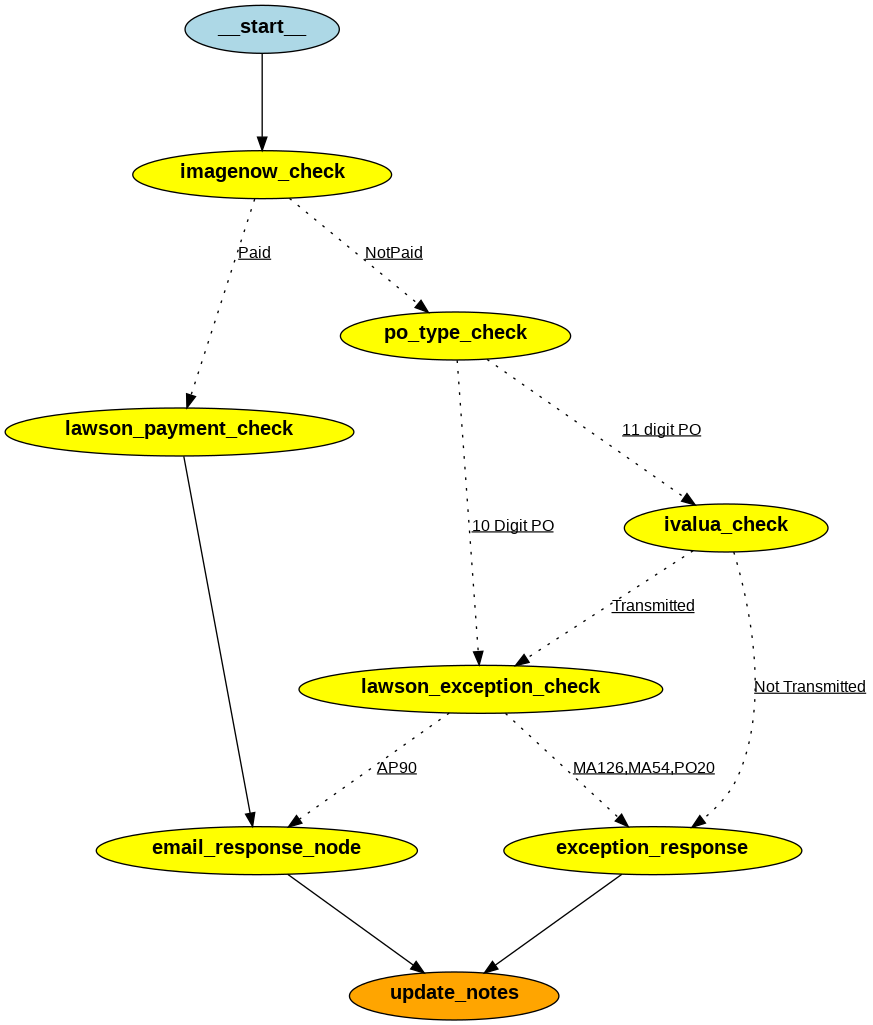

In [31]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
# Visualize the graph in a Jupyter notebook
Image(graph.get_graph().draw_png())

In [43]:
###Case 1 :
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV123456",
    po_number="12345678901",  # Example 11-digit PO
    is_paid=True,
    payment_method="",
    payment_date="",
    exception_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)


=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV123456 paid status: True

=== Conditional Check: Payment Status ===

=== Lawson Payment Check ===
Payment Method: Wire Transfer, Payment Date: 2025-01-05

=== Email Response Node ===
Drafting email to vendor using LLM...
Email Draft: Subject: Payment Confirmation for Invoice INV123456

Dear [Vendor's Name],

I hope this message finds you well.

I am writing to inform you that the payment for invoice INV123456 has been successfully processed. The payment was made via Wire Transfer on January 5, 2025.

If you have any questions or require further information, please do not hesitate to reach out.

Thank you for your continued partnership.

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Phone Number]  
[Your Email Address]  

=== Update Notes ===
 | Notes updated in Imagenow/Ivalua


{'invoice_id': 'INV123456',
 'po_number': '12345678901',
 'is_paid': True,
 'payment_method': 'Wire Transfer',
 'payment_date': '2025-01-05',
 'exception_status': '',
 'action_taken': ' | Notes updated in Imagenow/Ivalua'}

In [71]:
###Case 2 :
 # Execute the workflow
state = InvoiceState(
    invoice_id="INV123456",
    po_number="12345678901",  # Example 11-digit PO
    is_paid=False,
    payment_method="",
    po_type="",
    payment_date="",
    exception_status="",
    transmission_status="",
    action_taken=""
)

print("\n=== Starting Workflow Execution ===")
# Use the invoke method to execute the graph with the initial state
graph.invoke(state)




=== Starting Workflow Execution ===

=== Imagenow Check ===
Invoice INV123456 paid status: False

=== Conditional Check: Payment Status ===
Checking PO type (11-digit or 10-digit)...
PO type determined: 11-digit

=== Conditional Check: PO Length ===

=== Ivalua Check ===
Ivalua status for PO 12345678901: Transmitted

=== Conditional Check: Ivalua Exception Handling ===

=== Lawson Exception Check ===
Exception status for PO 12345678901: MA126

=== Conditional Check: Exception Status ===
Routing to 'exception_response' node.

=== Exception Response Node ===
Drafting email to finance_team@example.com based on exception status: MA126
Email Draft to finance_team@example.com: Subject: Assistance Required for Invoice 12345678901 - Exception Status MA126

Dear Finance Team,

I hope this message finds you well.

I am writing to bring to your attention an issue we are experiencing with invoice 12345678901, which has been flagged with exception status MA126. 

Upon reviewing the invoice, it app

{'invoice_id': 'INV123456',
 'po_number': '12345678901',
 'is_paid': False,
 'payment_method': '',
 'payment_date': '',
 'po_type': '11-digit',
 'exception_status': 'MA126',
 'action_taken': ' | Notes updated in Imagenow/Ivalua',
 'transmission_status': 'Transmitted'}